# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
#pip install --upgrade scikit-learn - May need to use the terminal to update this prior to using the workspace.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing.imputation import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
cust = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
cust.head(3)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
missing_values = azdias.isnull().sum()
azdias = azdias.fillna(value=np.nan)

In [8]:
azdias = azdias.fillna(value=np.nan)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
# Perform an assessment of how much missing data there is in each column of the dataset.
def count_missing(data):
    missing_values = data.isnull().sum()
    print(missing_values)
    
missing_azdias = count_missing(azdias)
print(missing_azdias)

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

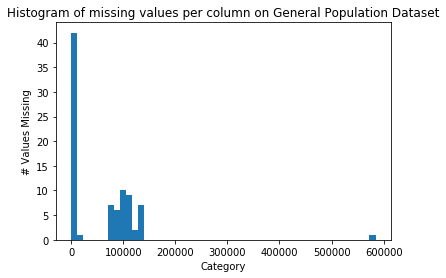

In [10]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_values, bins=50)
plt.xlabel('Category')
plt.ylabel('# Values Missing')
plt.title('Histogram of missing values per column on General Population Dataset')
plt.show()

In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
prct = ((missing_values/len(azdias))*100)
outlier_columns = prct[prct > 10].index
azdias_clean = azdias.drop(columns=outlier_columns)
print("Original General Population DataFrame shape:", azdias.shape)
print("Cleaned General Population DataFrame shape:", azdias_clean.shape)

Original General Population DataFrame shape: (891221, 85)
Cleaned General Population DataFrame shape: (891221, 50)


#### Discussion 1.1.2: Assess Missing Data in Each Column

<span style = 'color:Blue'>
Only one column is missing more than 15%+ of it's data, whereas 35 columns are missing 10%-15% of its data. I removed all columns missing ten or more percent of the data so that filling the values in don't skew available data when training the model. 
</span>

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [12]:
# How much data is missing in each row of the dataset?
missing_values_row = azdias_clean.isnull().sum(axis=1) 
azdias_clean['missing_values_count_row'] = missing_values_row
data_sorted_by_missing_values = azdias_clean.sort_values(by='missing_values_count_row', ascending = False)


In [13]:
subsets = azdias_clean.groupby('missing_values_count_row')
subset1 = pd.concat([group for key, group in subsets if key != 0])
subset2 = subsets.get_group(0)
print("Original General Population DataFrame shape:", azdias_clean.shape)
print("Removed from General Population DataFrame shape:", subset1.shape)
print("Cleaned General Population DataFrame shape:", subset2.shape)


Original General Population DataFrame shape: (891221, 51)
Removed from General Population DataFrame shape: (96697, 51)
Cleaned General Population DataFrame shape: (794524, 51)


In [14]:
subset2 = pd.DataFrame(subset2)

In [15]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def plotting(column_name):

    plt.figure(figsize=(15,10))

    plt.subplot(1, 2, 1)
    sns.countplot(x=column_name, data = subset1)
    plt.title('Subset 1 Frequencies')

    plt.subplot(1, 2, 2)
    sns.countplot(x=column_name, data = subset2)
    plt.title('Subset 2 Frequencies')

    plt.show()

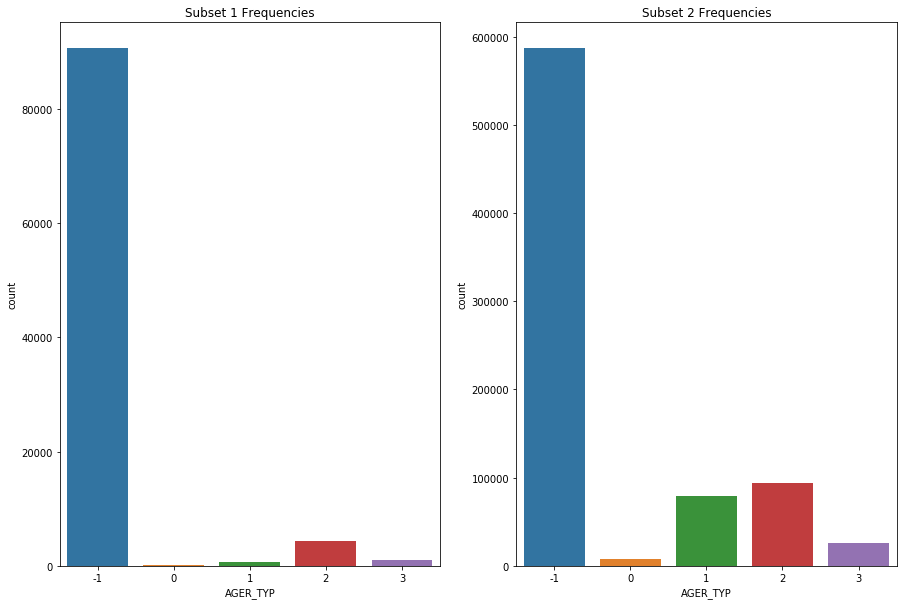

In [16]:
plotting('AGER_TYP')

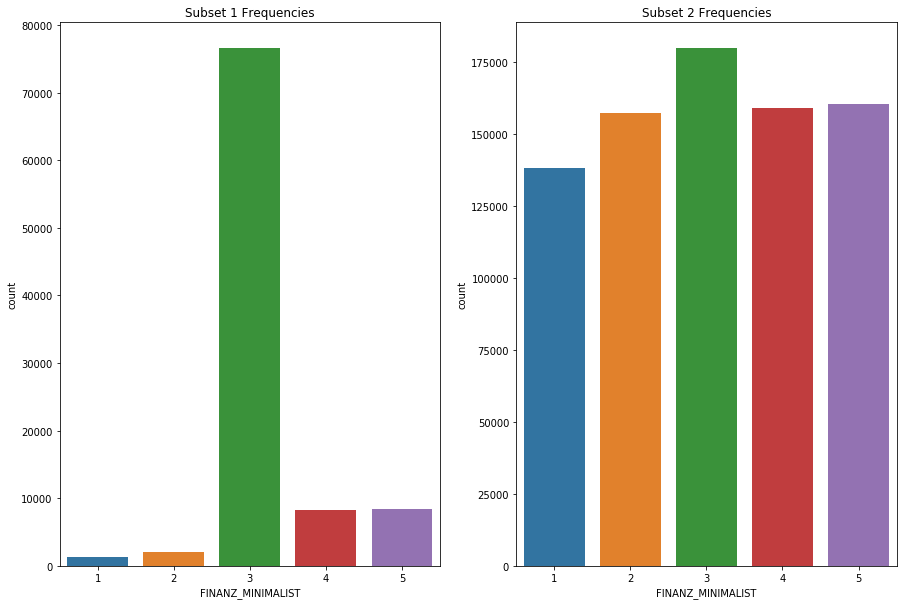

In [17]:
plotting('FINANZ_MINIMALIST')

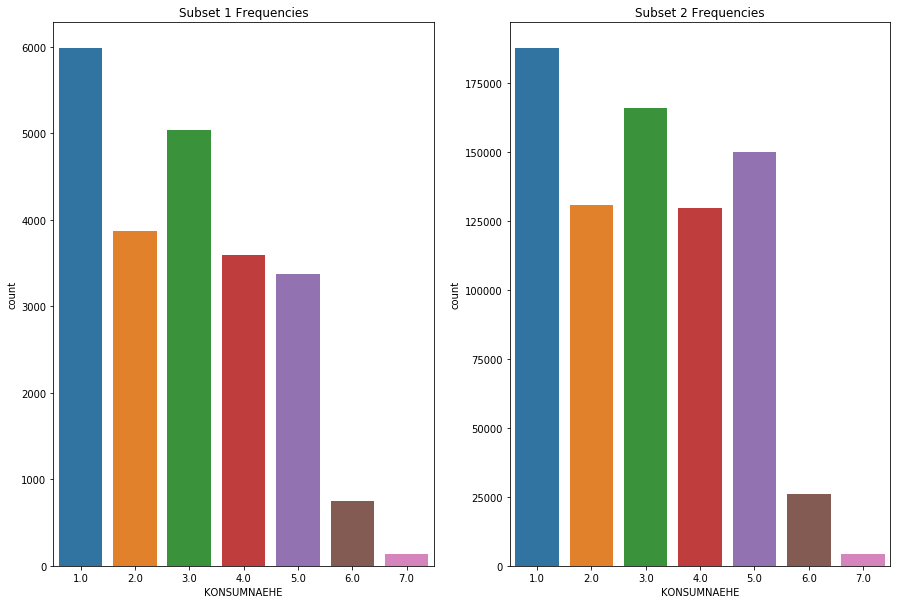

In [18]:
plotting('KONSUMNAEHE')

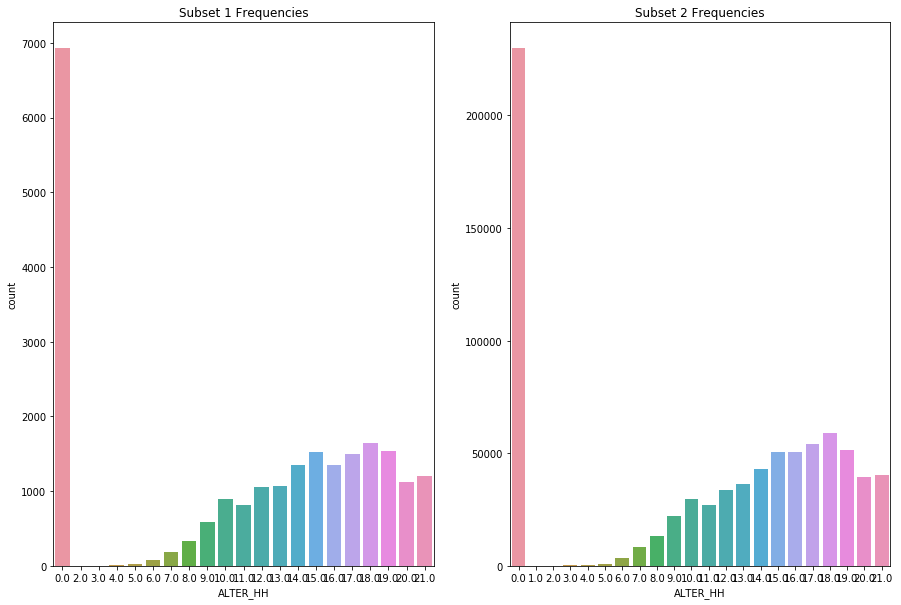

In [19]:
plotting('ALTER_HH')

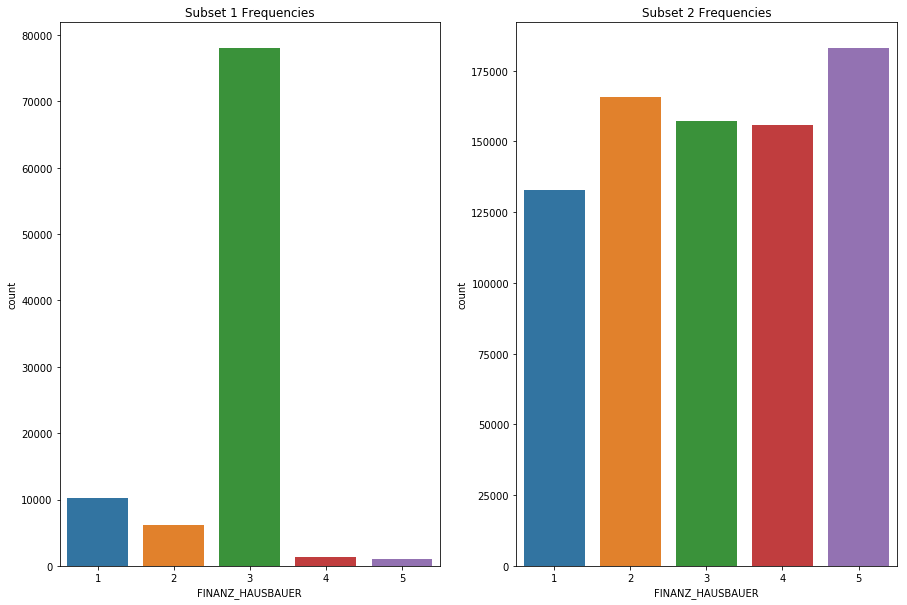

In [20]:
plotting('FINANZ_HAUSBAUER')

#### Discussion 1.1.3: Assess Missing Data in Each Row

<span style = 'color:Blue'>
I find the difference between subset2 and subset1's plots very interesting because separating rows with no missing values into a second subset presents a very different count of frequency for values in the five columns that I explored. For example, the scale for the column "ANREDE_KZ" changed drastically for the count of values between subset1 and subset2. The scaling difference was true for most of the five columns I explored, with subset2 having a larger scale. Other columns, such as "FINANZ_HAUSBUER" saw a shift in the freuqncy for the values, wich subset1 rows with a value of 3 showing a large frequency relative to other values, whereas the values in subset2 were more distributed.  
</span>

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [21]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [22]:
subset2.dtypes

AGER_TYP                      int64
ALTERSKATEGORIE_GROB          int64
ANREDE_KZ                     int64
CJT_GESAMTTYP               float64
FINANZ_MINIMALIST             int64
FINANZ_SPARER                 int64
FINANZ_VORSORGER              int64
FINANZ_ANLEGER                int64
FINANZ_UNAUFFAELLIGER         int64
FINANZ_HAUSBAUER              int64
FINANZTYP                     int64
GEBURTSJAHR                   int64
GFK_URLAUBERTYP             float64
GREEN_AVANTGARDE              int64
HEALTH_TYP                    int64
LP_LEBENSPHASE_FEIN         float64
LP_LEBENSPHASE_GROB         float64
LP_FAMILIE_FEIN             float64
LP_FAMILIE_GROB             float64
LP_STATUS_FEIN              float64
LP_STATUS_GROB              float64
NATIONALITAET_KZ              int64
PRAEGENDE_JUGENDJAHRE         int64
RETOURTYP_BK_S              float64
SEMIO_SOZ                     int64
SEMIO_FAM                     int64
SEMIO_REL                     int64
SEMIO_MAT                   

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [23]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_columns = []
mix_columns = []
re_en_columns = []

azdias_cols = subset2.columns

for index, row in feat_info.iterrows():
    if row['type'] == 'categorical':
        cat_columns.append(row['attribute'])
    elif row['type'] == 'mixed':
        mix_columns.append(row['attribute'])
        
print('The categorical columns are: ',cat_columns)
print('\n')
print('The mixed columns are: ', mix_columns)


The categorical columns are:  ['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


The mixed columns are:  ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']


In [24]:
binary_columns = []
multi_columns = []


for column in cat_columns:
    if column in subset2.columns:
        unique_values = subset2[column].nunique()
        if unique_values == 2:
            binary_columns.append(column)
        elif unique_values > 2:
            multi_columns.append(column)
    else:
        print(f"Column '{column}' does not exist in subset2.")
        
print('Binary columns:', binary_columns)
print('\n')
print('Multi-level columns:', multi_columns)

Column 'KK_KUNDENTYP' does not exist in subset2.
Column 'GEBAEUDETYP' does not exist in subset2.
Column 'OST_WEST_KZ' does not exist in subset2.
Column 'CAMEO_DEUG_2015' does not exist in subset2.
Column 'CAMEO_DEU_2015' does not exist in subset2.
Binary columns: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ']


Multi-level columns: ['AGER_TYP', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP']


In [25]:
 for column in binary_columns:
        if column in subset2.columns:
            unique_values = subset2[column].nunique()
            if unique_values == 2:
                if not pd.api.types.is_numeric_dtype(subset2[column]):
                    dummy_variable = pd.get_dummies(subset2[column], prefix=column, drop_first=True)
                    subset2.drop(column, axis=1, inplace=True)
                    subset2 = pd.concat([df, dummy_variable], axis=1)

In [26]:
 for column in multi_columns:
        if column in subset2.columns:
            unique_values = subset2[column].nunique()
            if unique_values > 2:
                if not pd.api.types.is_numeric_dtype(subset2[column]):
                    dummy_variable = pd.get_dummies(subset2[column], prefix=column, drop_first=True)
                    subset2.drop(column, axis=1, inplace=True)
                    subset2 = pd.concat([df, dummy_variable], axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

<span style = 'color:Blue'>
Three binary columns exist, and any binary column that takes on non-numeric values has been addressd using a dummy variable using get_dummies. There are more multilevel variables present, with 14 columns, and these were also encoded using dummy variables to convert categorical variables to numeric values for processing.
</span>


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [27]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables, one for generation and one for movement. Ordinal variable can be used for decade, and binary can be used for movement.
def decade_map(x):
    if x in [1, 2]:
        return 40
    elif x in [3, 4]:
        return 60
    elif x in [5, 6]:
        return 80
    elif x == 7:
        return 2000
    elif x == 8:
        return 2010
    else:
        return np.nan

subset2['decade'] = subset2['PRAEGENDE_JUGENDJAHRE'].apply(decade_map)

In [28]:
def movement_map(x):
    if x in [1, 3, 5, 8, 10, 12, 14]:
        return 1
    elif x in [2, 4, 6, 7, 9, 11, 13, 15]:
        return 0
    else:
        return np.nan

subset2['movement'] = subset2['PRAEGENDE_JUGENDJAHRE'].apply(movement_map)
subset2['movement'].head(5)

1    1.0
2    0.0
3    1.0
4    1.0
5    1.0
Name: movement, dtype: float64

#### Discussion 1.2.2: Engineer Mixed-Type Features

<span style = 'color:Blue'>
To deal with the mixed-type features I started by creating a function to set the generation to disect the data into the 40s, 60s, 80s, 2000s, and 2010s. This rough breakdown should help disaggregate different generational statuses. I used a binary approach to handle the 'movement' feature since there were only two values. 
    
"CAMEO_INTL_2015" does not exist in subset2 after cleaning the data, so life and wealth stage in this column did not need to be engineered.
</span>

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [29]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

#I don't think I have any additional tasks since I was able to use ordinal encoding and one-hot encoding on the categorical data types
#to encode them. 

In [30]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
subset2.drop(columns='PRAEGENDE_JUGENDJAHRE', inplace=True)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [31]:
def clean_data(data, feat_info):
    data_clean = data.copy()
    missing_values_row = data_clean.isnull().sum(axis=1) 
    data_clean['missing_values_count_row'] = missing_values_row
    #Create subsets of data
    subsets = data_clean.groupby('missing_values_count_row')
    data_1 = pd.concat([group for key, group in subsets if key != 0])
    data_2 = subsets.get_group(0)
#identify cat, mix, and re_encoded columns
    cat_columns = []
    mix_columns = []
    re_en_columns = []
    data_cols = data_2.columns
    for index, row in feat_info.iterrows():
        if row['type'] == 'categorical':
            cat_columns.append(row['attribute'])
        elif row['type'] == 'mixed':
            mix_columns.append(row['attribute'])
#Determine if binary or multi-level 
    binary_columns = []
    multi_columns = []
    for column in cat_columns:
        if column in data_2.columns:
            unique_values = data_2[column].nunique()
            if unique_values == 2:
                binary_columns.append(column)
            elif unique_values > 2:
                multi_columns.append(column)
#Encoding binary in need of encoding and multi-level 
    for column in binary_columns:
        if column in data_2.columns:
            unique_values = data_2[column].nunique()
            if unique_values == 2:
                if not pd.api.types.is_numeric_dtype(data_2[column]):
                    dummy_variable = pd.get_dummies(data_2[column], prefix=column, drop_first=True)
                    #data_2.drop(column, axis=1, inplace=True)
                    data_2 = pd.concat([data_2, dummy_variable], axis=1)
    for column in multi_columns:
        if column in data_2.columns:
            unique_values = data_2[column].nunique()
            if unique_values > 2:
                if not pd.api.types.is_numeric_dtype(data_2[column]):
                    dummy_variable = pd.get_dummies(data_2[column], prefix=column, drop_first=True)
                    data_2.drop(column, axis=1, inplace=True)
                    data_2 = pd.concat([data_2, dummy_variable], axis=1)
# Deal with "PRAEGENDE_JUGENDJAHRE" 
    data_2['decade'] = data_2['PRAEGENDE_JUGENDJAHRE'].apply(decade_map)
    data_2['movement'] = data_2['PRAEGENDE_JUGENDJAHRE'].apply(movement_map)
    columns=('PRAEGENDE_JUGENDJAHRE')
    if 'PRAEGENDE_JUGENDJAHRE' in data_2.columns:
        data_2.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    data_2.replace('XX', np.nan, inplace=True)  
    data_2.replace('X', np.nan, inplace=True)  
    data_2.replace('W', np.nan, inplace=True)  
    data_2.replace('O', np.nan, inplace=True)  
    #Make sure the columns are consistent
    data_2_columns = data_2.columns.tolist()
    missing_columns = [col for col in subset2_scaled.columns if col not in data_2_columns]
    for col in missing_columns:
        data_2[col] = 0  # Add missing columns and set values to 0 (or any other appropriate default value)
    # Reorder the columns in data_2 to match the column order in subset2_scaled
    data_2 = data_2[subset2_scaled.columns]
#Impute?
    imputer = Imputer(strategy='mean')
    imputer.fit(data_2)
    data_2 = pd.DataFrame(imputer.transform(data_2), columns=data_2.columns)
    return data_2

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [32]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imputer = Imputer(strategy='mean')
imputer.fit(subset2)

subset2 = pd.DataFrame(imputer.transform(subset2), columns=subset2.columns)

In [33]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()

scaler.fit(subset2)
subset2_scaled = pd.DataFrame(scaler.transform(subset2), columns=subset2.columns)
subset2 = subset2_scaled.copy()

### Discussion 2.1: Apply Feature Scaling
Source: https://analyticsindiamag.com/why-data-scaling-is-important-in-machine-learning-how-to-effectively-do-it/#:~:text=So%20if%20the%20data%20in,between%20them%20will%20be%20lower.

<span style = 'color:Blue'>
I used an imputer to replace all NaN with the mean of the dataset in order to be able to scale. I opted to not drop the values because I want to see what develops with the imputer. If I am unhappy or think that the analysis may be off I will go back and adjust by removing the rows with missing values.
    
Once the imputer replaced all NaNs, I used a standard scaler to resize the ditribution of values so that the mean of observed values is 0 and the standard deviation is 1. This will help by centering around the mean of all data in the feature.
</span>

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [34]:
# Apply PCA to the data.
def do_pca(n_components, data, column_names):
    pca = PCA(n_components)
    data_pca = pca.fit_transform(data)
    data_pca_df = pd.DataFrame(data_pca, columns=[f"PC{i+1}" for i in range(n_components)])
    data_pca_df.columns = column_names[:n_components]
    return pca, data_pca_df

In [35]:
pca, data_pca_df = do_pca(30,subset2, subset2.columns)

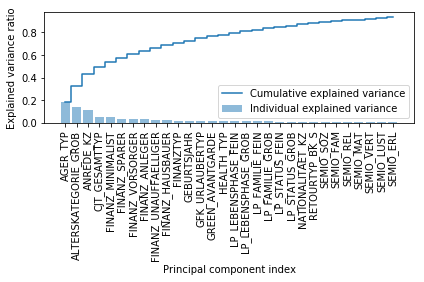

In [36]:
# Investigate the variance accounted for by each principal component.
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)

plt.bar(range(0, len(explained_var_ratio)), explained_var_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0, len(cumulative_var_ratio)), cumulative_var_ratio, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.xticks(range(0, len(explained_var_ratio)), data_pca_df.columns, rotation=90)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

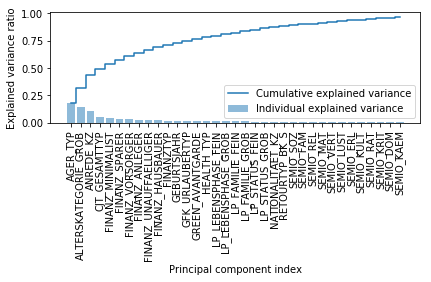

In [37]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca, data_pca_df = do_pca(35,subset2, subset2.columns)


explained_var_ratio = pca.explained_variance_ratio_

cumulative_var_ratio = np.cumsum(explained_var_ratio)

plt.bar(range(0,len(explained_var_ratio)), explained_var_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cumulative_var_ratio)), cumulative_var_ratio, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.xticks(range(0, len(explained_var_ratio)), data_pca_df.columns, rotation=90)
plt.legend(loc='best')
plt.tight_layout()


plt.show()

### Discussion 2.2: Perform Dimensionality Reduction

I am using 35 features for the next steps of the analysis because it captures almost all of the variance in the data, which has over 80 columns. This will retain a large portion of the information while still reducing the size of the dataset.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [38]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def print_pca_weights(pca, x,feat_num):
    x = pd.DataFrame(x)
    weights = pca.components_[feat_num]
    feature_weights = {}
    for i in range(len(weights)):
        feature_weights[x.columns[i]]  = weights[i]
    sorted_weights = sorted(feature_weights.items(), key=lambda x: x[1], reverse=True)
    for feature, weight in sorted_weights:
            print("{} {}".format(feature,weight))

def plot_pca_weights(pca, x, feat_num):
    x = pd.DataFrame(x)
    weights = pca.components_[feat_num]
    feature_weights = {}
    for i in range(len(weights)):
        feature_weights[x.columns[i]]  = weights[i]
    sorted_weights = sorted(feature_weights.items(), key=lambda x: x[1], reverse=True)
    features, weights = zip(*sorted_weights)
    plt.bar(features, weights)
    plt.xticks(rotation=90)
    plt.show()

ALTERSKATEGORIE_GROB 0.25656386935948206
FINANZ_VORSORGER 0.25155147778648806
FINANZ_MINIMALIST 0.22251144743014803
SEMIO_ERL 0.20424230194736234
SEMIO_LUST 0.18277768451507406
AGER_TYP 0.1705502246285706
LP_STATUS_GROB 0.15569827861012372
LP_STATUS_FEIN 0.13918762194820292
RETOURTYP_BK_S 0.1389015796273045
FINANZTYP 0.13785341323624828
LP_LEBENSPHASE_FEIN 0.10397477144573955
WOHNDAUER_2008 0.09441847455695035
GREEN_AVANTGARDE 0.08987309314145593
SHOPPER_TYP 0.08956636585709735
LP_LEBENSPHASE_GROB 0.08851878018412372
SEMIO_KRIT 0.05507704606631232
KONSUMNAEHE 0.051632817371833284
ANZ_PERSONEN 0.04075544086617574
LP_FAMILIE_GROB 0.03815960934698886
LP_FAMILIE_FEIN 0.03782468441223155
VERS_TYP 0.036867201097103654
SEMIO_KAEM 0.03396814895219727
ANREDE_KZ 0.031175263272209167
SEMIO_DOM 0.01663960360019351
ANZ_TITEL 0.011780354875705008
TITEL_KZ 0.009715394773967373
SEMIO_VERT 0.006779397681672731
SOHO_KZ 0.000621786330787311
missing_values_count_row 0.0
GEBURTSJAHR -0.012091272433368081
H

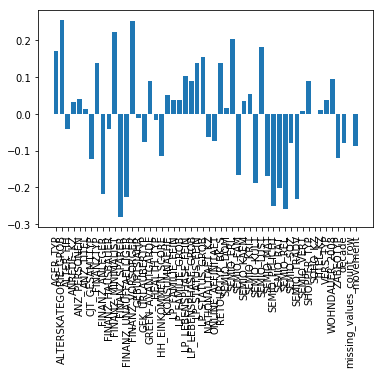

In [39]:
print_pca_weights(pca, subset2,0)
plot_pca_weights(pca, subset2,0)

SEMIO_VERT 0.23800031596493915
LP_LEBENSPHASE_FEIN 0.23309305276481712
LP_LEBENSPHASE_GROB 0.2278068383703231
LP_FAMILIE_GROB 0.20852645107470583
LP_STATUS_GROB 0.20814847155420496
LP_STATUS_FEIN 0.20754722821997765
LP_FAMILIE_FEIN 0.2064230206857995
SEMIO_KULT 0.2054477145937038
ANZ_PERSONEN 0.19513637196875652
FINANZ_MINIMALIST 0.18963064751797737
SEMIO_FAM 0.1826570423733375
SEMIO_SOZ 0.17263578170757718
ONLINE_AFFINITAET 0.1676459875023928
GREEN_AVANTGARDE 0.15694568756076782
SEMIO_REL 0.11497137658391904
ALTER_HH 0.10329998815016209
KONSUMNAEHE 0.09311658556031523
SEMIO_MAT 0.07432186049213707
GEBURTSJAHR 0.06270392624803378
SEMIO_TRADV 0.050244711197482084
FINANZTYP 0.04922964808130468
CJT_GESAMTTYP 0.04639830781524443
WOHNDAUER_2008 0.04116712869702672
HEALTH_TYP 0.04032861184665828
FINANZ_UNAUFFAELLIGER 0.038287609555691195
SEMIO_PFLICHT 0.03008862993288915
VERS_TYP 0.02553812741878209
NATIONALITAET_KZ 0.019237873923598395
ANZ_TITEL 0.012241383253861255
TITEL_KZ 0.0067316803066

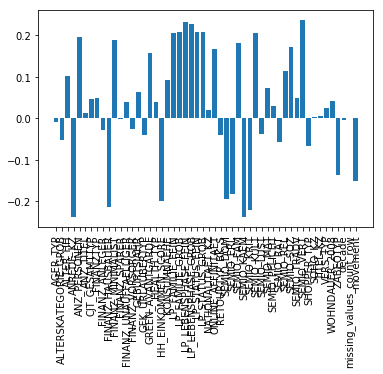

In [40]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_pca_weights(pca, subset2,1)
plot_pca_weights(pca, subset2,1)

ANREDE_KZ 0.28841106730993826
SEMIO_KAEM 0.2619891276996367
SEMIO_DOM 0.25747163386802907
LP_FAMILIE_GROB 0.2404748369977259
LP_FAMILIE_FEIN 0.23614580723470988
LP_LEBENSPHASE_GROB 0.22949599752952246
LP_LEBENSPHASE_FEIN 0.22693033948394525
ANZ_PERSONEN 0.20766328939220785
ONLINE_AFFINITAET 0.19541864278482599
SEMIO_RAT 0.19187421177022862
SEMIO_KRIT 0.18153487883029276
FINANZ_ANLEGER 0.16136076028193036
ALTER_HH 0.12373014474261604
SEMIO_ERL 0.12071235152025117
LP_STATUS_FEIN 0.11488890288309704
FINANZ_UNAUFFAELLIGER 0.11100460424142114
LP_STATUS_GROB 0.10297508950245216
SEMIO_TRADV 0.0926354248106575
SHOPPER_TYP 0.08843192691692556
FINANZ_SPARER 0.08831941416496188
GREEN_AVANTGARDE 0.08472688249360927
GEBURTSJAHR 0.08446074838608486
CJT_GESAMTTYP 0.0764821583678964
KONSUMNAEHE 0.07598424636958194
SEMIO_PFLICHT 0.07477911953377436
decade 0.03415163407720246
NATIONALITAET_KZ 0.016804408853438837
WOHNDAUER_2008 0.014133562039511804
HEALTH_TYP 0.013802807647757601
SOHO_KZ 0.0033326557257

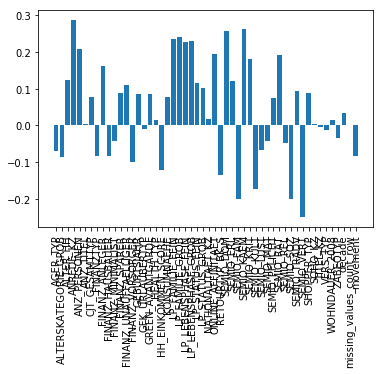

In [41]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_pca_weights(pca, subset2,2)
plot_pca_weights(pca, subset2,2)


### Discussion 2.3: Interpret Principal Components

Positive and negative values for the top three components demonstrate that there is a large weight attributed to personality typology in each of the principal components, and some of these typologies have a positive weight while others have a negative. Life stage, family type, social status, financial typology, and gender also carry weight in these principal components. This information is based on analyzing the weights with absolute values of .2.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

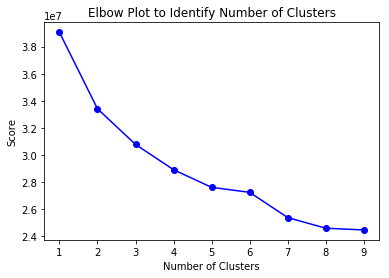

Clusters are:         cluster_label
0                   2
1                   2
2                   0
3                   1
4                   2
5                   2
6                   1
7                   0
8                   2
9                   0
10                  1
11                  2
12                  0
13                  2
14                  2
15                  0
16                  2
17                  1
18                  1
19                  1
20                  1
21                  1
22                  1
23                  1
24                  0
25                  2
26                  1
27                  2
28                  0
29                  0
...               ...
794494              0
794495              2
794496              0
794497              1
794498              0
794499              2
794500              0
794501              1
794502              1
794503              2
794504              1
794505              2
794506            

In [42]:
#My original elbow plot was taking too long to process, so I decided to look for alternatives. I found mini-batch k-means, and decided to give it a try.
#https://www.geeksforgeeks.org/ml-mini-batch-k-means-clustering-algorithm/#
def kmeans_apply(num_clust_min, num_clust_max, data, batch_size=50):
    score_plt_values = []
    for k in range(num_clust_min, num_clust_max):
        kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size)
        kmeans.fit(data)
        score = abs(kmeans.score(data))
        score_plt_values.append(score)
    plt.plot(range(num_clust_min, num_clust_max), score_plt_values, 'o-', color='blue')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Score")
    plt.title("Elbow Plot to Identify Number of Clusters")
    plt.show()

# Over a number of different cluster counts... 8 is the best, see the discussion.
kmeans_apply(1, 10, data_pca_df)

# run k-means clustering on the data and...
kmeans = MiniBatchKMeans(n_clusters=3, batch_size=50)
kmeans.fit(data_pca_df)   
clusters = pd.DataFrame(kmeans.predict(data_pca_df), columns=['cluster_label'])
print("Clusters are:", clusters)
    
# compute the average within-cluster distances.
score = abs(kmeans.score(data_pca_df))
print("Within-culster average distance is", score)

### Discussion 3.1: Apply Clustering to General Population

After running the function to determine the best number of clusters, 3 was determine the be the best fit, as values after 8 saw a smaller slope, meanming that there were less gains.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [43]:
# Load in the customer demographics data.
cust = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
if 'PRAEGENDE_JUGENDJAHRE' in cust.columns:
    cust2 = cust[['PRAEGENDE_JUGENDJAHRE']]
    # Rest of your code
else:
    print("Column 'PRAEGENDE_JUGENDJAHRE' not found in the DataFrame.")

In [44]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
cust2 = clean_data(cust, feat_info)

# Apply feature scaling to the general population demographics data.
cust2_subset = cust2[subset2_scaled.columns]
cust2_scaled = pd.DataFrame(scaler.transform(cust2_subset), columns=subset2_scaled.columns)

In [45]:
cust2_pca = pca.transform(cust2)
cust_clusters = pd.DataFrame(kmeans.predict(cust2_pca),columns=['cluster_label'])
print(cust_clusters)

       cluster_label
0                  1
1                  2
2                  2
3                  2
4                  2
5                  1
6                  2
7                  2
8                  2
9                  2
10                 1
11                 1
12                 2
13                 2
14                 2
15                 1
16                 2
17                 2
18                 2
19                 1
20                 2
21                 1
22                 2
23                 2
24                 1
25                 2
26                 1
27                 2
28                 2
29                 2
...              ...
69376              2
69377              2
69378              2
69379              2
69380              2
69381              2
69382              2
69383              2
69384              1
69385              2
69386              1
69387              1
69388              2
69389              2
69390              1
69391        

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

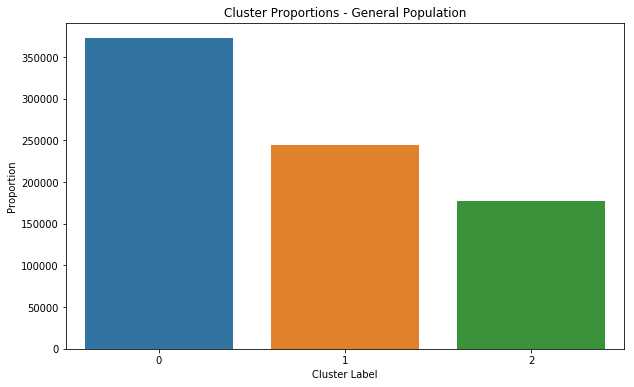

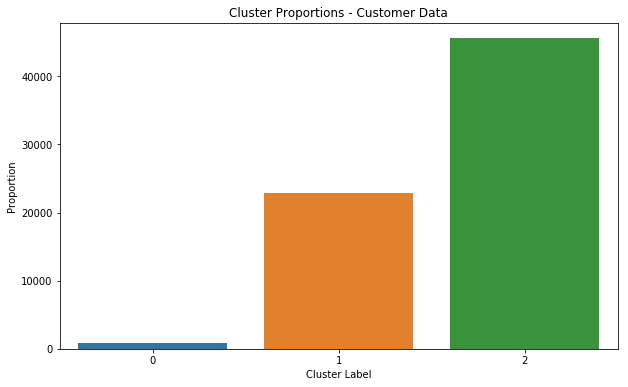

In [46]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
general_population_proportions = clusters['cluster_label'].value_counts(normalize=True)

# Compute cluster proportions for the customer data
customer_data_proportions = cust_clusters['cluster_label'].value_counts(normalize=True)

# Plot the cluster proportions for the general population
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster_label', data=clusters)
plt.title('Cluster Proportions - General Population')
plt.xlabel('Cluster Label')
plt.ylabel('Proportion')
plt.show()

# Plot the cluster proportions for the customer data
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster_label', data=cust_clusters)
plt.title('Cluster Proportions - Customer Data')
plt.xlabel('Cluster Label')
plt.ylabel('Proportion')
plt.show()


In [47]:
cust2['cluster_label'] = cust_clusters
subset2['cluster_label'] = clusters
cust2_proportions = cust2['cluster_label'].value_counts(normalize=True)
subset2_proportions = subset2['cluster_label'].value_counts(normalize=True)

aligned_proportions = cust2_proportions.align(subset2_proportions, fill_value=0)

overrepresented_clusters = aligned_proportions[0] > aligned_proportions[1]
overrepresented_cluster_labels = overrepresented_clusters[overrepresented_clusters].index
print("Overrepresented Cluster(s):", overrepresented_cluster_labels)

Overrepresented Cluster(s): Int64Index([1, 2], dtype='int64')


In [48]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
underrepresented_clusters = aligned_proportions[0] < aligned_proportions[1]
underrepresented_cluster_labels = underrepresented_clusters[underrepresented_clusters].index

print("Underrepresented Cluster(s):", underrepresented_cluster_labels)

Underrepresented Cluster(s): Int64Index([0], dtype='int64')


In [57]:
def clust_char(clust):
    cluster_means = []
    cluster_labels = clust['cluster_label'].unique()
    for indic in cluster_labels:
        cluster_indices = np.where(clust['cluster_label'].values == indic)[0]
        cluster_data = subset2.iloc[cluster_indices]
        mean_characteristics = cluster_data.mean()
        cluster_means.append(mean_characteristics)

        print("Cluster number:", indic)
        print(mean_characteristics)
    cluster_means_df = pd.DataFrame(cluster_means, columns=['Attribute', 'Values'])
    cluster_means_df = cluster_means_df.sort_values(by='Values', ascending=False)
    return pd.DataFrame(cluster_means_df, cluster_labels)

chars = clust_char(cust2[cust2['cluster_label'] == 2])

Cluster number: 2
AGER_TYP                    0.005162
ALTERSKATEGORIE_GROB        0.004970
ANREDE_KZ                   0.009913
CJT_GESAMTTYP              -0.003617
FINANZ_MINIMALIST          -0.017309
FINANZ_SPARER               0.001565
FINANZ_VORSORGER            0.011293
FINANZ_ANLEGER             -0.000731
FINANZ_UNAUFFAELLIGER      -0.005134
FINANZ_HAUSBAUER            0.018060
FINANZTYP                  -0.000432
GEBURTSJAHR                -0.005783
GFK_URLAUBERTYP            -0.002253
GREEN_AVANTGARDE           -0.006617
HEALTH_TYP                 -0.003287
LP_LEBENSPHASE_FEIN        -0.002816
LP_LEBENSPHASE_GROB        -0.000951
LP_FAMILIE_FEIN             0.002942
LP_FAMILIE_GROB             0.003009
LP_STATUS_FEIN             -0.023854
LP_STATUS_GROB             -0.022500
NATIONALITAET_KZ            0.000098
RETOURTYP_BK_S              0.007898
SEMIO_SOZ                  -0.009103
SEMIO_FAM                  -0.010891
SEMIO_REL                  -0.007258
SEMIO_MAT           

In [61]:
chars = clust_char(cust2[cust2['cluster_label'] == 1])

Cluster number: 1
AGER_TYP                    0.003809
ALTERSKATEGORIE_GROB        0.001976
ANREDE_KZ                   0.014071
CJT_GESAMTTYP              -0.000117
FINANZ_MINIMALIST          -0.030470
FINANZ_SPARER               0.004189
FINANZ_VORSORGER            0.005006
FINANZ_ANLEGER              0.002842
FINANZ_UNAUFFAELLIGER      -0.007696
FINANZ_HAUSBAUER            0.033068
FINANZTYP                  -0.000526
GEBURTSJAHR                -0.004112
GFK_URLAUBERTYP             0.008550
GREEN_AVANTGARDE           -0.024246
HEALTH_TYP                 -0.001991
LP_LEBENSPHASE_FEIN        -0.014850
LP_LEBENSPHASE_GROB        -0.013470
LP_FAMILIE_FEIN            -0.008879
LP_FAMILIE_GROB            -0.007514
LP_STATUS_FEIN             -0.040273
LP_STATUS_GROB             -0.038112
NATIONALITAET_KZ            0.005088
RETOURTYP_BK_S              0.007724
SEMIO_SOZ                  -0.012481
SEMIO_FAM                  -0.007950
SEMIO_REL                  -0.007801
SEMIO_MAT           

In [62]:
chars = clust_char(cust2[cust2['cluster_label'] == 0])

Cluster number: 0
AGER_TYP                   -0.028030
ALTERSKATEGORIE_GROB        0.006066
ANREDE_KZ                  -0.028954
CJT_GESAMTTYP               0.010046
FINANZ_MINIMALIST           0.009160
FINANZ_SPARER               0.029374
FINANZ_VORSORGER           -0.028137
FINANZ_ANLEGER             -0.003164
FINANZ_UNAUFFAELLIGER       0.049551
FINANZ_HAUSBAUER           -0.032107
FINANZTYP                  -0.032197
GEBURTSJAHR                 0.002755
GFK_URLAUBERTYP             0.019685
GREEN_AVANTGARDE            0.047841
HEALTH_TYP                  0.022688
LP_LEBENSPHASE_FEIN        -0.060730
LP_LEBENSPHASE_GROB        -0.062448
LP_FAMILIE_FEIN            -0.058434
LP_FAMILIE_GROB            -0.065611
LP_STATUS_FEIN              0.029255
LP_STATUS_GROB              0.036777
NATIONALITAET_KZ           -0.037752
RETOURTYP_BK_S             -0.043779
SEMIO_SOZ                   0.052138
SEMIO_FAM                   0.049989
SEMIO_REL                  -0.027033
SEMIO_MAT           

### Discussion 3.3: Compare Customer Data to Demographics Data

For the third cluster, which was the one with overrepresentation, the three of the highest values indicated that the customers had less affinity for home ownership (FINANZ_HAUSBAUER 0.018060), were lower income (HH_EINKOMMEN_SCORE 0.014388), and had a lower affinity for dominant minded personality typology (SEMIO_DOM 0.012154). Cluster 3 also demonstrated that customers were low income earners through a low score for LP_STATUS_FEIN (-0.023854) and LP_STATUS_GROB(-0.022500), and had a high affinity for little financial interest (FINANZ_MINIMALIST -0.017309).

The under represented groups had some similarities between cluster 1 and 2. The highest values indicated that there were more women in the  underrepresetned cluster (Cluster 2 ANREDE_KZ 0.014071), a lower affinity for family minded personality (Cluster 1 SEMIO_FAM 0.049989), a short length of residence (Cluster 2 and 3 WOHNDAUER_2008 -0.109902+), and a lower number of adults in household (Cluster 1 ANZ_PERSONEN -0.089430).

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.